
# Boston Liquor License Equity & Concentration Analysis

This notebook analyzes liquor license distribution in Boston with a focus on:

- Equity of access by ZIP code
- Market concentration
- Gatekeeping effects
- Policy compliance

Data Source: Licensing Board Minutes (2020–2026)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,6)


In [2]:
# Unique SAM Zips
SAM_ZIPS=['02026', '02108', '02109', '02110', '02111', '02113', '02114', '02115', '02116', '02118', '02119', 
'02120', '02121', '02122', '02124', '02125', '02126', '02127', '02128', '02129', '02130', '02131', '02132', 
'02134', '02135', '02136', '02152', '02163', '02186', '02199', '02210', '02215', '02445', '02446', '02458', 
'02467']

In [3]:
import geopandas as gpd

# Load Boston ZCTA GeoJSON
boston_map = gpd.read_file("../data/boston_zcta.geojson")

# Inspect
boston_map.head()

,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,02132,02132,860Z200US02132,B5,G6350,S,12597745,248598,+42.2790822,-071.1604493,"POLYGON ((-71.19123 42.283, -71.19119 42.28304..."
1,02116,02116,860Z200US02116,B5,G6350,S,1681929,429920,+42.3509789,-071.0765907,"POLYGON ((-71.09124 42.35434, -71.091 42.3544,..."
2,02163,02163,860Z200US02163,B5,G6350,S,475171,0,+42.3672264,-071.1250920,"POLYGON ((-71.13107 42.36703, -71.13105 42.367..."
3,02186,02186,860Z200US02186,B5,G6350,S,35472536,1251664,+42.2415592,-071.0824366,"POLYGON ((-71.13075 42.22791, -71.13072 42.227..."
4,02135,02135,860Z200US02135,B5,G6350,S,6732791,118310,+42.3496885,-071.1539638,"POLYGON ((-71.17485 42.35034, -71.1748 42.3505..."


## Load and Clean Data

In [4]:

df = pd.read_excel("../data/licenses.xlsx")

df["minutes_date"] = pd.to_datetime(df["minutes_date"], errors="coerce")

df["zipcode"] = (
    df["zipcode"]
    .astype("Int64")
    .astype(str)
    .str.zfill(5)
)

df.head()


,minutes_date,license_number,business_name,dba_name,address,street_number,street_name,city,state,zipcode,alcohol_type,manager,attorney,status,status_detail,details,entity_number,file_name
0,2026-01-28,LB-99709,"'Wichcraft, LLC",New England Wicked Craft Company,"54 Salem St, Boston, MA 02113",54,Salem St,Boston,MA,02113,wines and malt beverages,NaN,NaN,granted,Granted,Holder of a Common Victualler 7 Day Wines and ...,13,voting_minutes_2026-01-29.pdf
1,2026-01-28,LB-99286,Alasty Corp.,Napper Tandy's,"4187-4195 Washington St, Roslindale, MA 02131",4187-4195,Washington St,Roslindale,MA,02131,all alcoholic beverages,Callejas,Mark A. White,continued,Continued to the February 11 Transactional Hea...,Holder of a Common Victualler 7 Day All-Alcoho...,15,voting_minutes_2026-01-29.pdf
2,2026-01-28,LB-100327,"AYA Pizza, LLC",Red Line Pizza,"580-582 Dorchester Ave, South Boston, MA 02127",580-582,Dorchester Ave,South Boston,MA,02127,all alcoholic beverages,NaN,NaN,granted,"Granted, for delivery only between 11:00 PM an...",Holder of a Common Victualler License has peti...,2,voting_minutes_2026-01-29.pdf
3,2026-01-28,LB-99607,"Bop Productions, LLC",Bebop,"1116 Boylston St, Boston, MA 02115",1116,Boylston St,Boston,MA,02115,wines and malt beverages,NaN,NaN,granted,Granted,Holder of a Common Victualler 7 Day Wines and ...,12,voting_minutes_2026-01-29.pdf
4,2026-01-28,LB-454368,"BPM Events, LLC",Boston Public Market,"100 Hanover St, Boston, MA 02108",100,Hanover St,Boston,MA,02108,all alcoholic beverages,NaN,Dennis A. Quilty,granted,Granted,Holder of a Common Victualler 7 Day All-Alcoho...,5,voting_minutes_2026-01-29.pdf


## Basic Overview

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   minutes_date    2454 non-null   datetime64[us]
 1   license_number  2465 non-null   str           
 2   business_name   2465 non-null   str           
 3   dba_name        2197 non-null   str           
 4   address         2459 non-null   str           
 5   street_number   2389 non-null   str           
 6   street_name     2457 non-null   str           
 7   city            2458 non-null   str           
 8   state           2453 non-null   str           
 9   zipcode         2457 non-null   str           
 10  alcohol_type    2376 non-null   str           
 11  manager         1162 non-null   str           
 12  attorney        1531 non-null   str           
 13  status          2463 non-null   str           
 14  status_detail   2463 non-null   str           
 15  details        

In [6]:
df.describe(include='all')

,minutes_date,license_number,business_name,dba_name,address,street_number,street_name,city,state,zipcode,alcohol_type,manager,attorney,status,status_detail,details,entity_number,file_name
count,2454,2465,2465,2197,2459,2389,2457,2458,2453,2457,2376,1162,1531,2463,2463,2462,2465.000000,2465
unique,NaN,1500,1712,1462,1921,885,330,16,1,29,2,880,220,7,213,2211,NaN,133
top,NaN,LB-99098,"Colwen Management, Inc.",Star Market,"100 Legends Way, Boston, MA 02114",1,Boylston St,Boston,MA,02116,all alcoholic beverages,Patel,Dennis A. Quilty,granted,Granted,Holder of a Common Victualler 7 Day All-Alcoho...,NaN,voting_minutes_2025-02-13.pdf
freq,NaN,8,13,10,16,88,139,1396,2453,273,1779,10,193,2166,1591,11,NaN,64
mean,2023-05-07 05:06:18.484107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.786613,NaN
min,2020-04-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN
50%,2023-04-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN
75%,2024-11-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN
max,2026-01-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,NaN


## Filter Granted Licenses

In [7]:

granted_or_active = df[
    df["status"]
    .fillna("")
    .str.lower()
    .isin(["granted", "active"])
].copy()

len(granted_or_active)


2191

In [8]:
deduped = (
    granted_or_active
    .assign(
        minutes_date=lambda df: pd.to_datetime(
            df["minutes_date"],
            errors="coerce"
        )
    )
    .sort_values("minutes_date", ascending=False)
    .drop_duplicates(
        subset="license_number",
        keep="first"
    )
)

print(deduped.shape)


(1386, 18)


## Equity Analysis: Licenses per ZIP

In [9]:

licenses_by_zip = (
    deduped.groupby("zipcode")
    .size()
    .reset_index(name="licenses")
    .sort_values("licenses", ascending=False)
)

licenses_by_zip.head(10)


,zipcode,licenses
17,02128,156
7,02116,138
26,02210,104
27,02215,84
16,02127,75
6,02115,68
8,02118,57
5,02114,56
22,02134,55
3,02111,54


## Census Overlay (Optional)

In [10]:
# Force ZIP codes to strings when loading census data
census = pd.read_csv("../data/census_zip_pop.csv", dtype={"zipcode": str})

# Make sure your licenses ZIPs are also strings and zero-padded
licenses_by_zip["zipcode"] = licenses_by_zip["zipcode"].astype(str).str.zfill(5)

# Now merge safely
merged = licenses_by_zip.merge(census, on="zipcode")

merged.head()
#merged.columns


,zipcode,licenses,population,poverty_rate,median_income,median_gross_rent,rent_burden
0,02128,156,45357,0.141610,84023,12644,0.150483
1,02116,138,22286,0.133537,131648,7746,0.058839
2,02210,104,5706,0.033824,179643,2854,0.015887
3,02215,84,24522,0.171519,64138,7613,0.118697
4,02127,75,36175,0.104022,145357,9667,0.066505


In [11]:
# Ensure ZIP codes are strings and padded
merged["zipcode"] = merged["zipcode"].astype(str).str.zfill(5)

# Licenses per 10k people
merged["licenses_per_10k"] = merged["licenses"] / merged["population"] * 10000

# City average per-capita licenses
city_avg = merged["licenses_per_10k"].mean()

# Equity index = relative to city average
merged["equity_index"] = merged["licenses_per_10k"] / city_avg

# Display top/bottom ZIPs by equity index
merged.sort_values("equity_index", ascending=False)[["zipcode", "licenses", "population", "licenses_per_10k", "equity_index"]].head(10)


,zipcode,licenses,population,licenses_per_10k,equity_index
2,02210,104,5706,182.264283,4.297777
13,02110,42,2337,179.717587,4.237726
23,02199,18,1221,147.420147,3.476155
16,02109,39,3559,109.581343,2.583919
14,02108,40,4218,94.831674,2.236123
12,02113,47,6688,70.275120,1.657081
9,02111,54,8417,64.155875,1.512790
1,02116,138,22286,61.922283,1.460122
7,02114,56,13356,41.928721,0.988676
0,02128,156,45357,34.393809,0.811003


In [12]:
# Optional: weighted “socioeconomic equity score”
# High poverty + low access → high need
merged["socioeconomic_equity"] = (1 - merged["equity_index"]) * merged["poverty_rate"]

# Optional: rank ZIPs by need
merged["equity_rank"] = merged["socioeconomic_equity"].rank(ascending=False)

# Preview
merged[["zipcode","licenses","population","licenses_per_10k","equity_index","poverty_rate","socioeconomic_equity","equity_rank"]].head(10)


,zipcode,licenses,population,licenses_per_10k,equity_index,poverty_rate,socioeconomic_equity,equity_rank
0,02128,156,45357,34.393809,0.811003,0.141610,0.026764,20.0
1,02116,138,22286,61.922283,1.460122,0.133537,-0.061443,22.0
2,02210,104,5706,182.264283,4.297777,0.033824,-0.111544,25.0
3,02215,84,24522,34.254955,0.807729,0.171519,0.032978,19.0
4,02127,75,36175,20.732550,0.488872,0.104022,0.053169,16.0
5,02115,68,27838,24.427042,0.575988,0.204109,0.086545,12.0
6,02118,57,28392,20.076078,0.473392,0.253593,0.133544,8.0
7,02114,56,13356,41.928721,0.988676,0.108715,0.001231,21.0
8,02134,55,17969,30.608270,0.721740,0.212588,0.059155,14.0
9,02111,54,8417,64.155875,1.512790,0.249376,-0.127878,26.0


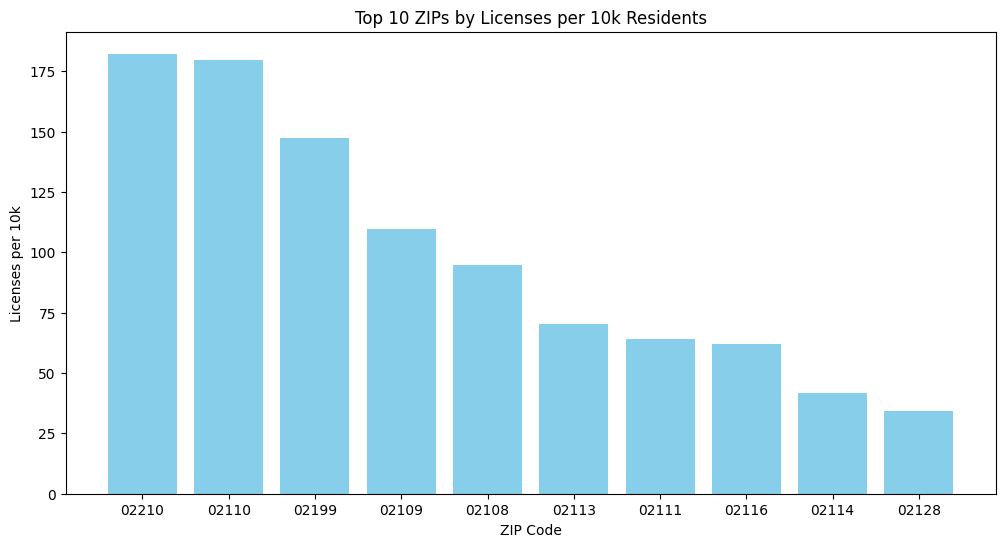

In [13]:
import matplotlib.pyplot as plt

top10 = merged.sort_values("licenses_per_10k", ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.bar(top10["zipcode"], top10["licenses_per_10k"], color="skyblue")
plt.title("Top 10 ZIPs by Licenses per 10k Residents")
plt.ylabel("Licenses per 10k")
plt.xlabel("ZIP Code")
plt.show()


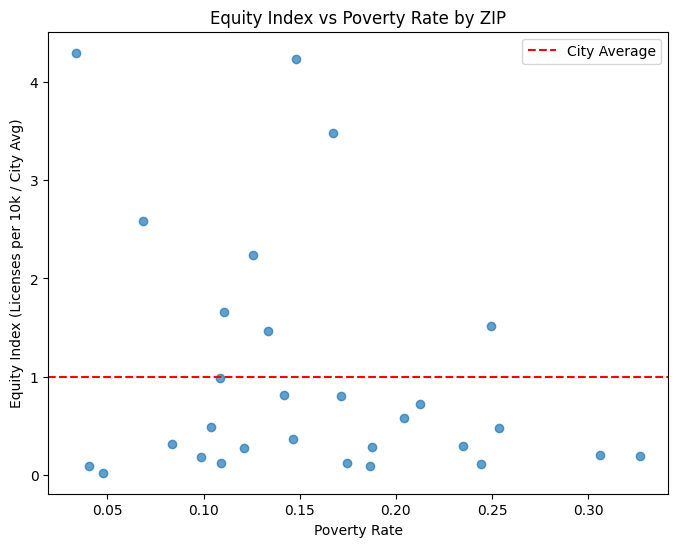

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(merged["poverty_rate"], merged["equity_index"], alpha=0.7)
plt.axhline(1, color='red', linestyle='--', label='City Average')
plt.xlabel("Poverty Rate")
plt.ylabel("Equity Index (Licenses per 10k / City Avg)")
plt.title("Equity Index vs Poverty Rate by ZIP")
plt.legend()
plt.show()


In [15]:
# Ensure ZIP codes are strings and zero-padded
merged["zipcode"] = merged["zipcode"].astype(str).str.zfill(5)
boston_map["ZCTA5CE20"] = boston_map["ZCTA5CE20"].astype(str).str.zfill(5)

# Merge equity metrics into GeoDataFrame
map_df = boston_map.merge(merged, left_on="ZCTA5CE20", right_on="zipcode")


In [16]:
# Ensure numeric types
merged["population"] = pd.to_numeric(merged["population"], errors="coerce")
merged["licenses"] = pd.to_numeric(merged["licenses"], errors="coerce")

# Licenses per 10k residents
merged["licenses_per_10k"] = merged["licenses"] / merged["population"] * 10000

# Boston average per-capita licenses
city_avg = merged["licenses_per_10k"].mean()

# Equity index relative to city average
merged["equity_index"] = merged["licenses_per_10k"] / city_avg

# Optional: clamp extremes for plotting
merged["equity_index_clamped"] = merged["equity_index"].clip(0, 2)

# Check distribution
merged[["zipcode","licenses","population","licenses_per_10k","equity_index"]].sort_values("equity_index")


,zipcode,licenses,population,licenses_per_10k,equity_index
28,02467,2,21709,0.921277,0.021724
27,02132,10,26488,3.775294,0.089021
26,02126,10,24994,4.000960,0.094342
24,02121,14,29820,4.694836,0.110704
22,02136,20,39498,5.063548,0.119398
18,02124,29,55336,5.240711,0.123576
20,02131,25,31637,7.902140,0.186332
25,02120,12,14364,8.354219,0.196992
21,02119,23,26821,8.575370,0.202207
11,02130,48,41479,11.572121,0.272870


<Figure size 1000x1000 with 0 Axes>

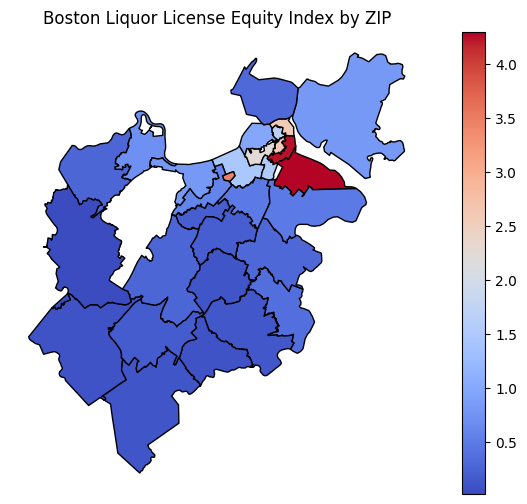

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
map_df.plot(
    column="equity_index",      # Metric to color by
    cmap="coolwarm",            # Color map
    legend=True,                # Show legend
    edgecolor="black"
)
plt.title("Boston Liquor License Equity Index by ZIP")
plt.axis("off")
plt.show()


“While Boston’s liquor licenses are not monopolized, nearly one-third are held by multi-location operators — raising questions about whether independent and first-time owners face structural disadvantages.”


The Herfindahl–Hirschman Index (HHI) for liquor license ownership in Boston is approximately 10.7, indicating a highly fragmented ownership structure with no evidence of monopolization or dominant firms. At the same time, multi-location operators account for approximately 31.6% of all granted licenses. Taken together, these measures suggest that while ownership is broadly dispersed, a substantial minority of licenses are held by multi-location operators. 



## Market Concentration (HHI)

In [19]:

owners = deduped.groupby("business_name").size()
shares = owners / owners.sum()

hhi = (shares ** 2).sum() * 10000
hhi


np.float64(9.755356075702396)

In [20]:

top10 = owners.sort_values(ascending=False).head(10)
top10


business_name
Delaware North Boston Flight, LLC                     8
Sodexo Operations, LLC                                7
Healing Homes of Boston, LLC                          6
HSI MCA BOS FB, LLC                                   5
Northeastern University                               5
Cantina Hospitality, LLC                              4
Castle Island C2H, LLC                                4
Delta Air Lines, Inc.                                 4
Cisco Brewers, Distillers & Vintners Fenway, Inc.     4
Cisco Brewers, Distillers, Vintners, Seaport, Inc.    4
dtype: int64

## Chain Penetration

In [21]:

locations = (
    deduped.groupby("business_name")["address"]
    .nunique()
    .reset_index(name="locations")
)

chains = locations[locations["locations"] > 1]

chain_licenses = deduped[
    deduped["business_name"].isin(chains["business_name"])
]

chain_index = len(chain_licenses) / len(deduped)
chain_index


0.1341991341991342

## Attorney Gatekeeping

In [24]:

attorney_stats = (
    deduped.dropna(subset=["attorney"])
    .groupby("attorney")
    .size()
    .reset_index(name="cases")
)

success = (
    deduped.groupby("attorney")["status"]
    .apply(lambda x: (x=="granted").mean())
    .reset_index(name="success_rate")
)

attorney_stats = attorney_stats.merge(success, on="attorney", how="left")

attorney_stats.sort_values("cases", ascending=False).head(10)


,attorney,cases,success_rate
46,Dennis A. Quilty,111,1.0
150,Thomas P. Miller,62,1.0
95,Kristen L. Scanlon,47,1.0
15,Andrew F. Upton,45,1.0
54,Elizabeth Pisano,31,1.0
77,John P. Connell,21,1.0
161,William G. Ferullo,17,1.0
80,Jon D. Aieta,17,1.0
81,Joseph H. Devlin,17,1.0
101,Lesley Delaney Hawkins,17,1.0


## Temporal Trends

In [25]:
import matplotlib.ticker as mticker

# Plot
plt.figure()
full_years.plot(marker="o")

plt.title("Granted Licenses per Year (Full Years Only)")
plt.ylabel("Count")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)

# Force integer ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.show()




NameError: name 'full_years' is not defined

<Figure size 1000x600 with 0 Axes>

## ZIP Code Distribution

In [ ]:

licenses_by_zip.plot(
    x="zipcode",
    y="licenses",
    kind="bar"
)

plt.title("Top ZIP Codes by License Count")
plt.show()


In [ ]:

licenses_by_town = (
    granted.groupby("city")
    .size()
    .reset_index(name="licenses")
    .sort_values("licenses", ascending=False)
)

licenses_by_town.plot(
    x="city",
    y="licenses",
    kind="bar"
)

plt.title("Towns by License Count")
plt.show()



## Key Findings (Draft)

Fill in after analysis.



## Methodology

- Source: Licensing Board Minutes PDFs
- Processing: Custom ETL
- Limitations noted.
